# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [2]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')


/home/dominiklewy/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Env setup

In [3]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [4]:
import warnings
warnings.filterwarnings('ignore')
from utils import label_map_util
from utils import visualization_utils as vis_util
warnings.filterwarnings('default')

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [5]:
# What model to download.
MODEL_NAME = 'face_training'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'object-detection.pbtxt')

NUM_CLASSES = 1

## Load a (frozen) Tensorflow model into memory.

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

/home/dominiklewy/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/dominiklewy/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [7]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [8]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [9]:
import pandas as pd
IMAGE_SIZE = (12, 8)

In [10]:
test = pd.read_csv("/media/dominiklewy/E260342F60340CB3/Users/dominik.lewy/Google Drive/KNOWLEDGE/COCO data/Exp1_face_detector/test.csv")
train = pd.read_csv("/media/dominiklewy/E260342F60340CB3/Users/dominik.lewy/Google Drive/KNOWLEDGE/COCO data/Exp1_face_detector/train.csv")

In [11]:
train.head()

,faces,filename,class,xmax,xmin,ymax,ymin,OK
0,[453 228 50 50],000000001000.jpg,face,503,453,278,228,yes
1,[239 184 28 28],000000001000.jpg,face,267,239,212,184,yes
2,[436 121 34 34],000000001000.jpg,face,470,436,155,121,yes
3,[155 115 168 168],000000001296.jpg,face,323,155,283,115,yes
4,[404 205 25 25],000000002299.jpg,face,429,404,230,205,yes


In [12]:
TEST_IMAGE_PATHS = "/media/dominiklewy/E260342F60340CB3/Users/dominik.lewy/Google Drive/KNOWLEDGE/COCO data/Exp1_face_detector/images/"+test.filename.unique()
TRAIN_IMAGE_PATHS = "/media/dominiklewy/E260342F60340CB3/Users/dominik.lewy/Google Drive/KNOWLEDGE/COCO data/Exp1_face_detector/images/"+train.filename.unique()

In [13]:
len(TEST_IMAGE_PATHS)

55

In [14]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [15]:
import cv2
# base HAAR extractor function. This function reads the image, converts it to grayscale, applies the face finder and 
# returns a vector with list of bbox for faces
def find_face(image):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier('/media/dominiklewy/E260342F60340CB3/Users/dominik.lewy/Google Drive/KNOWLEDGE/KARIERA IT/CNN part - old & new appraoch/Haar/haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5)
    return faces

## Detection - vizualization

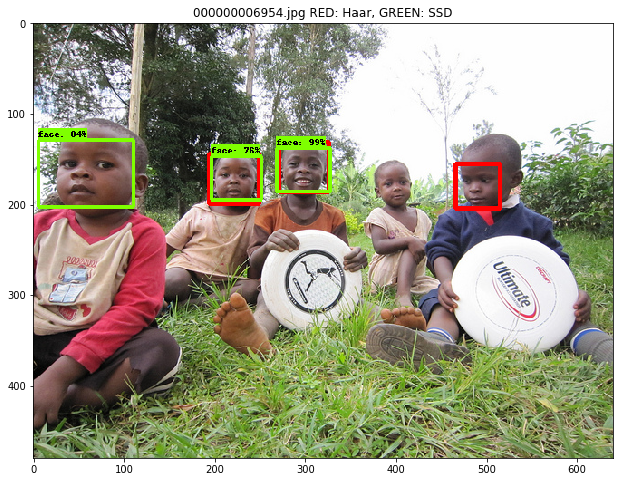

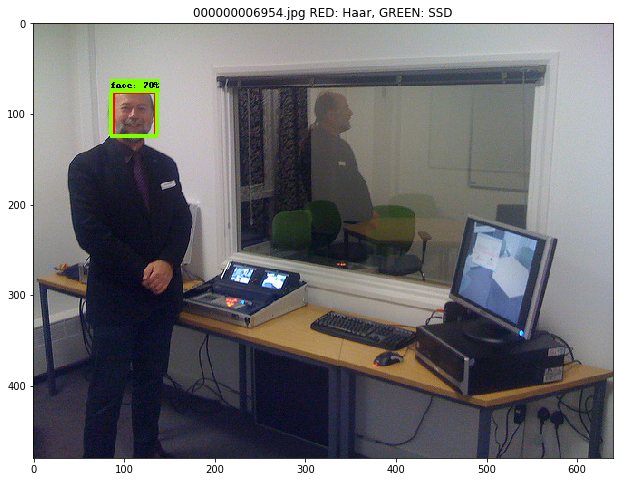

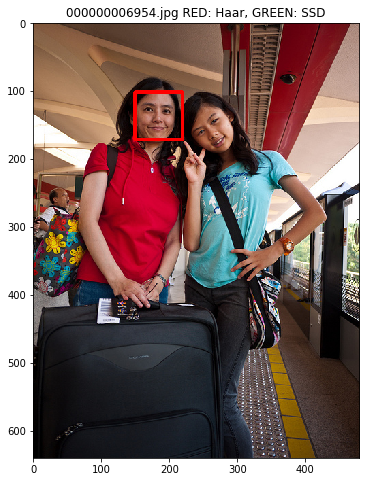

In [16]:
for image_path in TEST_IMAGE_PATHS[0:3]:
  image = Image.open(image_path)
  image = image.convert('RGB')
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  if len(image_np.shape) == 3:
        faces = find_face(image_np)
        for j in faces:
            x=j[0]
            y=j[1]
            w=j[2]
            h=j[3]
            cv2.rectangle(image_np, (x, y), (x+w, y+h), (255, 0, 0), 4)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=4)
  plt.figure(figsize=IMAGE_SIZE)
  plt.title(TEST_IMAGE_PATHS[0].split("/")[-1] + " RED: Haar, GREEN: SSD")
  plt.imshow(image_np)

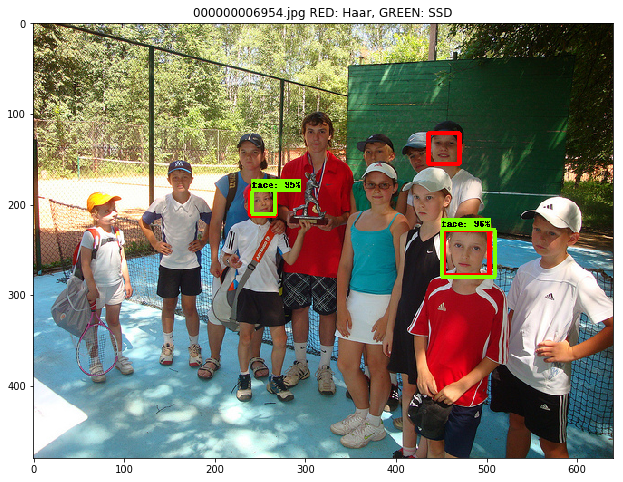

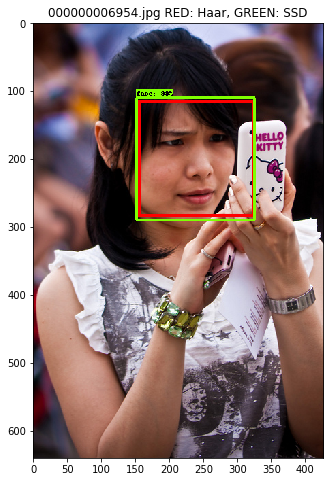

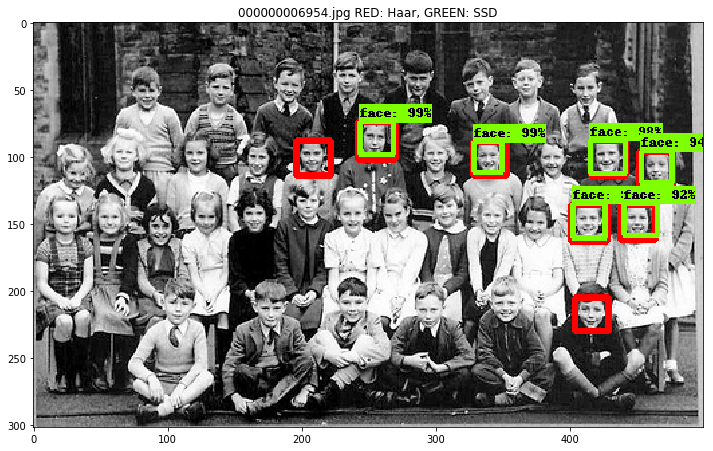

In [17]:
for image_path in TRAIN_IMAGE_PATHS[0:3]:
  image = Image.open(image_path)
  image = image.convert('RGB')
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  if len(image_np.shape) == 3:
        faces = find_face(image_np)
        for j in faces:
            x=j[0]
            y=j[1]
            w=j[2]
            h=j[3]
            cv2.rectangle(image_np, (x, y), (x+w, y+h), (255, 0, 0), 4)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=4)
  plt.figure(figsize=IMAGE_SIZE)
  plt.title(TEST_IMAGE_PATHS[0].split("/")[-1] + " RED: Haar, GREEN: SSD")
  plt.imshow(image_np)

## Detection - storing results

In [26]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  image = image.convert('RGB')
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  if len(image_np.shape) == 3:
        faces = find_face(image_np)
        for j in faces:
            x=j[0]
            y=j[1]
            w=j[2]
            h=j[3]
            cv2.rectangle(image_np, (x, y), (x+w, y+h), (255, 0, 0), 4)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=4)
  plt.imsave(fname="/media/dominiklewy/E260342F60340CB3/Users/dominik.lewy/Google Drive/KNOWLEDGE/COCO data/Exp1_face_detector/images_with_detections/TEST_"+image_path.split("/")[-1], arr = image_np)
    

In [27]:
for image_path in TRAIN_IMAGE_PATHS:
  image = Image.open(image_path)
  image = image.convert('RGB')
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  if len(image_np.shape) == 3:
        faces = find_face(image_np)
        for j in faces:
            x=j[0]
            y=j[1]
            w=j[2]
            h=j[3]
            cv2.rectangle(image_np, (x, y), (x+w, y+h), (255, 0, 0), 4)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=4)
  plt.imsave(fname="/media/dominiklewy/E260342F60340CB3/Users/dominik.lewy/Google Drive/KNOWLEDGE/COCO data/Exp1_face_detector/images_with_detections/TRAIN_"+image_path.split("/")[-1], arr = image_np)
    

## Detection - summary results

In [39]:
#source: https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [92]:
list_image = list()
list_Haar = list()
list_SSD = list()
list_found = list()
for image_path in TEST_IMAGE_PATHS:
  found_count = 0
  #print(image_path.split("/")[-1])
  image = Image.open(image_path)
  image = image.convert('RGB')
  image_np = load_image_into_numpy_array(image)
  image_np_expanded = np.expand_dims(image_np, axis=0)
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  if len(image_np.shape) == 3:
        faces = find_face(image_np)
        Haar_count = len(faces)
        for j in faces:
  #          print("Haar:")
            xmin=int(j[0])
            ymin=int(j[1])
            xmax=int(j[0]+j[2])
            ymax=int(j[1]+j[3])
  #          print((xmin,ymin,xmax,ymax))
            
            haar={
                    'x1': xmin,
                    'x2': xmax, 
                    'y1': ymin,
                    'y2': ymax
                }

  #          print("SSD:")
            ssd_list = list()
            SSD_count = len(output_dict["detection_boxes"][output_dict["detection_scores"]>0.5])
            for (a,b,c,d) in output_dict["detection_boxes"][output_dict["detection_scores"]>0.5]:
                img_shape = image_np.shape

                a = int(a*img_shape[0])
                b = int(b*img_shape[1])
                c = int(c*img_shape[0])
                d = int(d*img_shape[1])

  #              print((b,a,d,c))
                
                ssd={
                    'x1': b,
                    'x2': d, 
                    'y1': a,
                    'y2': c
                }
                IOU = get_iou(haar,ssd)
                ssd_list.append(IOU)
  #              print(get_iou(haar,ssd))
  #          print("######")
            if len(ssd_list)==0:
                found_count = 0
            else:
                if np.max(ssd_list) > 0.5:
                    found_count = found_count+1
  #print("found_count: ", found_count)
  #print("SSD_count: ", SSD_count)
  #print("Haar_count: ", Haar_count)
  list_image.append(image_path.split("/")[-1])
  list_Haar.append(Haar_count)
  list_SSD.append(SSD_count)
  list_found.append(found_count)

In [86]:
test_results = pd.DataFrame({"image":list_image, "SSD":list_SSD, "Haar":list_Haar, "matching":list_found})

In [87]:
test_results.to_csv("/media/dominiklewy/E260342F60340CB3/Users/dominik.lewy/Google Drive/KNOWLEDGE/COCO data/Exp1_face_detector/test_results.csv", index=False)
test_results.head()

,Haar,SSD,image,matching
0,3,3,000000006954.jpg,2
1,1,1,000000009483.jpg,1
2,1,0,000000011699.jpg,0
3,1,0,000000025394.jpg,0
4,1,0,000000032887.jpg,0


In [89]:
list_image = list()
list_Haar = list()
list_SSD = list()
list_found = list()
for image_path in TRAIN_IMAGE_PATHS:
  found_count = 0
  #print(image_path.split("/")[-1])
  image = Image.open(image_path)
  image = image.convert('RGB')
  image_np = load_image_into_numpy_array(image)
  image_np_expanded = np.expand_dims(image_np, axis=0)
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  if len(image_np.shape) == 3:
        faces = find_face(image_np)
        Haar_count = len(faces)
        for j in faces:
  #          print("Haar:")
            xmin=int(j[0])
            ymin=int(j[1])
            xmax=int(j[0]+j[2])
            ymax=int(j[1]+j[3])
  #          print((xmin,ymin,xmax,ymax))
            
            haar={
                    'x1': xmin,
                    'x2': xmax, 
                    'y1': ymin,
                    'y2': ymax
                }

  #          print("SSD:")
            ssd_list = list()
            SSD_count = len(output_dict["detection_boxes"][output_dict["detection_scores"]>0.5])
            for (a,b,c,d) in output_dict["detection_boxes"][output_dict["detection_scores"]>0.5]:
                img_shape = image_np.shape

                a = int(a*img_shape[0])
                b = int(b*img_shape[1])
                c = int(c*img_shape[0])
                d = int(d*img_shape[1])

  #              print((b,a,d,c))
                
                ssd={
                    'x1': b,
                    'x2': d, 
                    'y1': a,
                    'y2': c
                }
                IOU = get_iou(haar,ssd)
                ssd_list.append(IOU)
  #              print(get_iou(haar,ssd))
  #          print("######")
            if len(ssd_list)==0:
                found_count = 0
            else:
                if np.max(ssd_list) > 0.5:
                    found_count = found_count+1
  #print("found_count: ", found_count)
  #print("SSD_count: ", SSD_count)
  #print("Haar_count: ", Haar_count)
  list_image.append(image_path.split("/")[-1])
  list_Haar.append(Haar_count)
  list_SSD.append(SSD_count)
  list_found.append(found_count)

In [90]:
train_results = pd.DataFrame({"image":list_image, "SSD":list_SSD, "Haar":list_Haar, "matching":list_found})

In [91]:
train_results.to_csv("/media/dominiklewy/E260342F60340CB3/Users/dominik.lewy/Google Drive/KNOWLEDGE/COCO data/Exp1_face_detector/train_results.csv", index=False)
train_results.head()

,Haar,SSD,image,matching
0,3,2,000000001000.jpg,2
1,1,1,000000001296.jpg,1
2,8,6,000000002299.jpg,6
3,2,0,000000004134.jpg,0
4,4,4,000000005001.jpg,4
